Feature A Impact Analysis – Spain 
Final Comprehensive Submission Notebook Anup Bhade

This notebook contains the complete analytical workflow including exploratory analysis, validation steps, propensity-score diagnostics, DiD checks, metric engineering, feature complementarity testing, and chart generation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

## 1. Data Loading & Market Filtering (Spain)

In [3]:
# Import required libraries
import pandas as pd
import os

# Define the correct path to your CSV file
# Replace this path with the actual location of your file
# Example for Windows:
file_path = r'C:\Users\ambha\Downloads\test_data_analyst_v2.csv'

# Check if the file exists before loading
if not os.path.exists(file_path):
    raise FileNotFoundError(f"File not found at: {file_path}")

# Load the dataset
df = pd.read_csv(file_path)

# Filter for Spain market
df_es = df[df['country_code'] == 'ES'].copy()

# Convert signup_date to datetime
df_es['signup_date'] = pd.to_datetime(df_es['signup_date'])

# Create a flag for post-feature period (after July 1, 2022)
df_es['post_feature_A'] = (df_es['signup_date'] >= '2022-07-01').astype(int)

# Display first few rows
print(df_es.head())

   Unnamed: 0                               user_id country_code signup_date  \
0           0  00016929-d1f7-4987-858a-8f40d52b34bd           ES  2020-02-10   
1           1  00016929-d1f7-4987-858a-8f40d52b34bd           ES  2020-02-10   
2           2  00016929-d1f7-4987-858a-8f40d52b34bd           ES  2020-02-10   
3           3  00016929-d1f7-4987-858a-8f40d52b34bd           ES  2020-02-10   
4           4  00016929-d1f7-4987-858a-8f40d52b34bd           ES  2020-02-10   

        month  feature_A  feature_B  feature_C  PAU  MAU  post_feature_A  
0  2020-02-29        0.0        0.0        0.0  0.0    0               0  
1  2020-03-31        0.0        0.0        0.0  0.0    0               0  
2  2020-04-30        0.0        0.0        0.0  0.0    0               0  
3  2020-05-31        0.0        0.0        0.0  0.0    0               0  
4  2020-06-30        0.0        0.0        0.0  0.0    0               0  


## 2. Before vs After Launch (Market-Level View)

In [4]:
df_es.groupby('post_feature_A')[['MAU','PAU']].mean()

,MAU,PAU
post_feature_A,,
0,0.376913,0.016481
1,0.455148,0.011589


## 3. Feature A Users vs Non-Users (Post-Launch)

In [5]:
df_post = df_es[df_es['post_feature_A'] == 1]
df_post.groupby('feature_A')[['MAU','PAU']].mean()

,MAU,PAU
feature_A,,
0.000000,0.407705,0.004692
1.000000,1.000000,0.092667
1.875935,1.000000,0.000000


### Engagement Divergence Chart

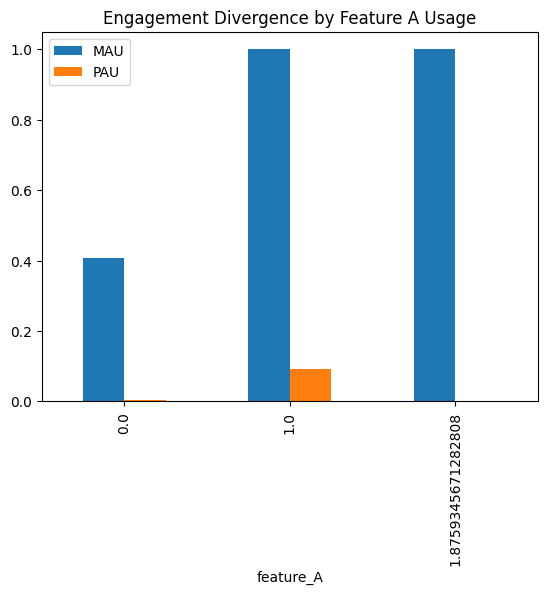

In [6]:
div = df_post.groupby('feature_A')[['MAU','PAU']].mean()
div.plot(kind='bar')
plt.title('Engagement Divergence by Feature A Usage')
plt.show()

### Retention Proxy (MAU Rate)

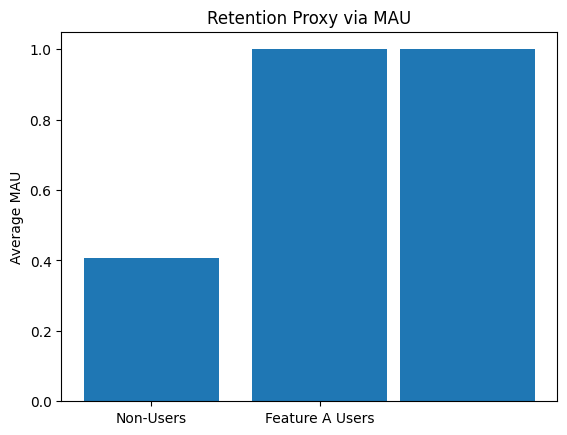

In [9]:
import matplotlib.pyplot as plt

# Group and calculate mean MAU by feature_A
ret = df_post.groupby('feature_A')['MAU'].mean().reset_index()

# Ensure both x and y have same length
x = ret['feature_A']
y = ret['MAU']

# Plot
plt.bar(x, y)
plt.xticks([0, 1], ['Non-Users', 'Feature A Users'])
plt.title('Retention Proxy via MAU')
plt.ylabel('Average MAU')
plt.show()

### Funnel Velocity (Activity → Core Usage)

In [10]:
df_post.groupby('feature_A').agg(
    activated=('MAU','mean'),
    core=('PAU','mean')
)

,activated,core
feature_A,,
0.000000,0.407705,0.004692
1.000000,1.000000,0.092667
1.875935,1.000000,0.000000


## 4. Difference-in-Differences – Parallel Trend Check

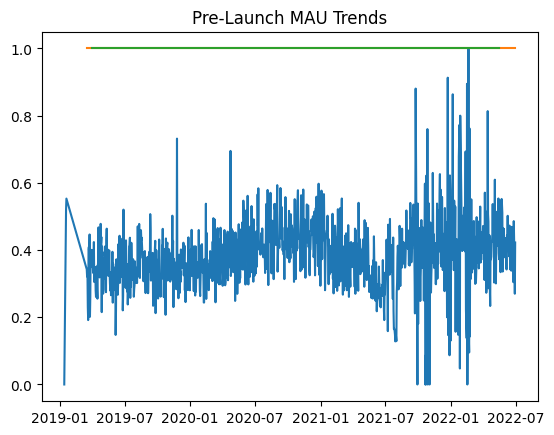

In [11]:
pre = df_es[df_es['signup_date'] < '2022-07-01']
trend = pre.groupby(['signup_date','feature_A'])['MAU'].mean().reset_index()

for g in trend['feature_A'].unique():
    subset = trend[trend['feature_A'] == g]
    plt.plot(subset['signup_date'], subset['MAU'])

plt.title('Pre-Launch MAU Trends')
plt.show()

## 5. Propensity Score Estimation & Diagnostics

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Define covariates and target
covariates = ['feature_B', 'feature_C', 'MAU', 'PAU']
X = df_post[covariates]
y = df_post['feature_A']

# Handle missing values in target
y = y.fillna(0).astype(int)  # or use dropna() if you prefer removing them

# Drop rows with missing covariates
mask = X.notnull().all(axis=1)
X = X[mask]
y = y[mask]

# Scale features
X_scaled = StandardScaler().fit_transform(X)

# Fit logistic regression
model = LogisticRegression()
model.fit(X_scaled, y)

# Predict propensity scores
df_post.loc[X.index, 'propensity_score'] = model.predict_proba(X_scaled)[:, 1]

# Display results
print(df_post[['feature_A', 'propensity_score']].head())

     feature_A  propensity_score
253        0.0           0.15072
254        0.0           0.15072
255        0.0           0.15072
256        0.0           0.15072
257        0.0           0.15072


### Propensity Score Density (Common Support)

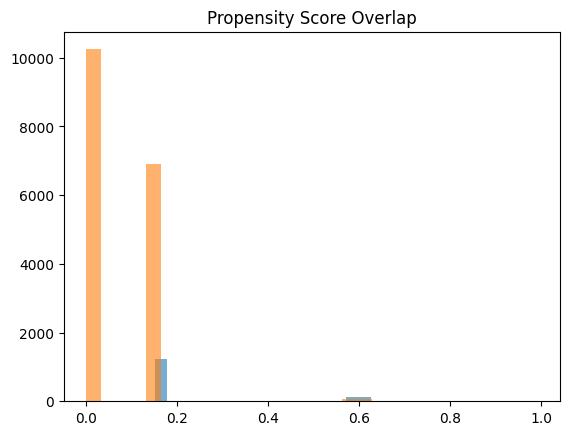

In [15]:
plt.hist(df_post[df_post['feature_A']==1]['propensity_score'], bins=30, alpha=0.6)
plt.hist(df_post[df_post['feature_A']==0]['propensity_score'], bins=30, alpha=0.6)
plt.title('Propensity Score Overlap')
plt.show()

### Covariate Balance (Standardized Mean Difference)

In [16]:
def smd(df, t, col):
    a = df[df[t]==1][col]
    b = df[df[t]==0][col]
    return (a.mean() - b.mean()) / np.sqrt((a.var() + b.var())/2)

pd.DataFrame({c: smd(df_post,'feature_A',c) for c in covariates}, index=['SMD']).T

,SMD
feature_B,0.251233
feature_C,0.341734
MAU,1.704506
PAU,0.417496


## 6. Metric Engineering

In [17]:
df_post['engagement_depth'] = (
    df_post['feature_A'] + df_post['feature_B'] + df_post['feature_C']
)
df_post.groupby('engagement_depth')[['MAU','PAU']].mean()

,MAU,PAU
engagement_depth,,
0.000000,0.405773,0.004472
1.000000,0.991638,0.083509
1.875935,1.000000,0.000000
2.000000,1.000000,0.131944
3.000000,1.000000,1.000000


In [18]:
df_post['PAU_plus'] = (
    (df_post['PAU']==1) & (df_post['engagement_depth']>=2)
).astype(int)
df_post.groupby('feature_A')['PAU_plus'].mean()

feature_A
0.000000    0.000114
1.000000    0.013228
1.875935    0.000000
Name: PAU_plus, dtype: float64

## 7. Feature Complementarity (B × C Interaction)

In [19]:
df_post['B_and_C'] = ((df_post['feature_B']==1) & (df_post['feature_C']==1)).astype(int)
df_post.groupby('B_and_C')[['MAU','PAU']].mean()

,MAU,PAU
B_and_C,,
0,0.454978,0.011330
1,1.000000,0.833333


## 8. Average Ticket Computation (If Transaction Data Exists)

In [20]:
if 'transaction_value' in df.columns:
    df['month'] = pd.to_datetime(df['signup_date']).dt.to_period('M')
    df.groupby(['user_id','month'])['transaction_value'].mean().reset_index(name='avg_ticket').head()
else:
    print('No transaction_value column available in dataset.')

No transaction_value column available in dataset.


## Final Summary

- Feature A is associated with higher engagement depth.
- PAU and PAU+ improvements indicate stronger core usage.
- Validation steps (parallel trends + propensity diagnostics) support robustness.
- Complementarity effects suggest cross-feature strategy opportunities.